# 02805 exercise 8
## Part A2 - Sentiment analysis

### Exercise 2: Sentiment within the communities data.
It's still OK to work with data from a single universe, and - unlike above - we work all communities.

> Download the LabMT wordlist. It's available as supplementary material from Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter (Data Set S1). Describe briefly how the list was generated.

In [1]:
# the list is stored in the file path : './data/DataSetS1.txt'

**Answer:**  
1. **Get the unique words for evaluation**: the researcher use four disparate text sources: Twitter, Google Books (English), music lyrics (1960 to 2007), and the New York Times (1987 to 2007). Get the most frequent words in each corpus, then the researchers merged the top 5,000 words from each source, resulting in a composite set of 10,222 unique words.
2. **Evaluate the sentiment level**: asked users on Mechanical Turk to rate how a given word made them feel on a nine point integer scale, obtaining 50 independent evaluations per word. (*maybe re-write it in our own words*) We broke the overall assignment into 100 smaller tasks of rating approximately 100 randomly assigned words at a time. We emphasized the scores 1, 3, 5, 7, and 9 by stylized faces, representing a sad to happy spectrum. Such five point scales are in widespread use on the web today (e.g., Amazon) and would likely be familiar with users. The four intermediate scores of 2, 4, 6, 8 allowed for fine tuning of assessments. 
3. **Notice that the researchers avoid stemming the words**

> Based on the LabMT word list, write a function that calculates sentiment given a list of tokens (the tokens should be lower case, etc).

**Answer:**  
Use Equation (1) in paper [Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752) to calculate the setiment score.
$$h_{avg}(T) = \frac{\sum_{i=1}^N h_{avg}(w_i)f_i}{\sum_{i=1}^N f_i}$$

In [17]:
# # First, get the information from the DataSetS1 

# # with dataframe, it is way too slow. So i change to dict again(i thought the dataframe might be more clear, but it is just too slow)
# import numpy as np
# import pandas as pd

# LabMT_wordlist_path = './data/DataSetS1.txt'
# line_cnt = 0

# LabMT_word_df = pd.DataFrame(columns=['word', 'happiness_rank','happiness_average', 'happiness_standard_deviation',\
#                                       'twitter_rank', 'google_rank', 'nyt_rank', 'lyrics_rank'])

# with open(LabMT_wordlist_path,'r') as f:
#     line = f.readline()
#     line_cnt +=1 
    
#     while line: 
        
#         if line_cnt <=4: # the words start at the 5th line
#             line = f.readline() 
#             line_cnt+= 1
#             continue
            
#         content = line.split('\t')
#         word = content[0]
#         happiness_rank = int(content[1])
#         happiness_average = float(content[2])
#         happiness_standard_deviation= float(content[3])
        
#         def get_rank_in_LabMT(string):
#             if string=='--':
#                 return np.nan
#             else:
#                 return int(string)
        
#         twitter_rank,google_rank,nyt_rank,lyrics_rank = get_rank_in_LabMT(content[4]),get_rank_in_LabMT(content[5]),\
#                                                         get_rank_in_LabMT(content[6]),get_rank_in_LabMT(content[7][:-1])
        
#         LabMT_word_df.append(pd.Series([word, happiness_rank,happiness_average, happiness_standard_deviation,\
#                                        twitter_rank,google_rank,nyt_rank,lyrics_rank], index=LabMT_word_df.columns ), ignore_index=True)
#         line = f.readline() 
#         line_cnt+= 1
# #         if line_cnt%100 == 0:
# #             print(line_cnt)


In [18]:
# First, get the information from the DataSetS1 
# store the information into LabMT_word_dict
import numpy as np

LabMT_wordlist_path = './data/DataSetS1.txt'
line_cnt = 0

LabMT_word_dict = {}

with open(LabMT_wordlist_path,'r') as f:
    line = f.readline()
    line_cnt +=1 
    
    while line: 
        if line_cnt <=4: # the words start at the 5th line
            line = f.readline() 
            line_cnt+= 1
            continue
            
        content = line.split('\t')
        word = content[0]
        happiness_rank = int(content[1])
        happiness_average = float(content[2])
        happiness_standard_deviation= float(content[3])
        
        def get_rank_in_LabMT(string):
            if string=='--':
                return np.nan
            else:
                return int(string)
        
        twitter_rank,google_rank,nyt_rank,lyrics_rank = get_rank_in_LabMT(content[4]),get_rank_in_LabMT(content[5]),\
                                                        get_rank_in_LabMT(content[6]),get_rank_in_LabMT(content[7][:-1])
        
        infor_dict = {'happiness_rank':happiness_rank, 'happiness_average':happiness_average,\
                     'happiness_standard_deviation': happiness_standard_deviation,\
                     'twitter_rank':twitter_rank, 'google_rank':google_rank,\
                     'nyt_rank':nyt_rank, 'lyrics_rank':lyrics_rank}
        
        LabMT_word_dict[word] = infor_dict
        
        line = f.readline() 
        line_cnt+= 1


In [22]:
import nltk

def sentiment_calculator(list_of_token):
    freqDict = nltk.FreqDist(list_of_token)
    # filter freqDict, only leave the ones in the LabMT_wordlist
    freqDict_filter = {k: v for k, v in freqDict.items() if k in LabMT_word_dict.keys()}
    
    sum_weight_freq = 0
    for w in freqDict_filter.keys():
        sum_weight_freq += freqDict_filter[w]*LabMT_word_dict[w]['happiness_average']
    sum_all_freq = sum(freqDict_filter.values())
    
    return sum_weight_freq/sum_all_freq

> Iterage over the nodes in your network, tokenize each page, and calculate sentiment every single page. Now you have sentiment as a new nodal property.

In [25]:
# step0: get the marvel network first

# get the name for file saving and reading
def file_saving_reading_name(s):
    s = s.replace(':','@')
    s = s.replace('/','$')
    return s

# get the name with ':' and '/'
def node_name(s):
    s = s.replace('@',':')
    s = s.replace('$','/')
    return s

# load the nodes and edges from pre-dumped json file
import json
file_path = './data/comics_cha.json'
with open(file_path, 'r') as f:
    data = json.load(f)
    
import networkx as nx

# bulid the network from data 
G = nx.DiGraph()

# get the attribute from comics_cha
attr_dict = {}
for each in data:
    attr_dict[each] = data[each]['type']

# add nodes    
G.add_nodes_from(data.keys())
# add attribute of type
nx.set_node_attributes(G, attr_dict,'type')


# add links
for each in data:
    for link in data[each]['edges']:
        G.add_edge(each,link)
        
print('number of nodes in network:{}'.format(len(G.nodes())))
print('number of links in network:{}'.format(len(G.edges())))

# get the undirected version of the whole network
G_undirect = G.to_undirected()

# get the list of DC/Marvel characters
dc_cha = []
marvel_cha = []
for node in G_undirect.nodes():
    if nx.get_node_attributes(G_undirect,'type')[node] == 'Marvel':
        marvel_cha.append(node)
    else:
        dc_cha.append(node)

# get the subgraph from the list
DC_network = G_undirect.subgraph(dc_cha)
Marvel_network = G_undirect.subgraph(marvel_cha)

print('number of node in Marvel universe:{}'.format(len(Marvel_network.nodes())))
print('number of edge in Marvel universe:{}'.format(len(Marvel_network.edges())))

number of nodes in network:2277
number of links in network:33461
number of node in Marvel universe:1238
number of edge in Marvel universe:15850


In [31]:
# step1: get the text from each node and tranform the text into list of token


# define the funtion to generate the raw word text(with punctuation marks) from a raw_text
from nltk.tokenize import word_tokenize
import nltk
porter = nltk.PorterStemmer()

# get the list of token from raw text
def get_word_list(raw_text):
    token = word_tokenize(raw_text)
    # PROBLEM HERE (just wanna to remove \n with an easier way)
#     pattern =  r'[a-zA-Z0-9\-]+'
#     tokenize_nopunc = []
#     for w in token:   
#         tokenize_nopunc.extend(re.findall(pattern,w))
    tokenize_nopunc= [w for w in token if w.isalpha()]
    tokenize_nopunc_lower = [w.lower() for w in tokenize_nopunc]
#     tokenize_nopunc_lower_lemmatize = [porter.stem(w) for w in tokenize_nopunc_lower]
    tokenize_nopunc_lower_lemmatize = tokenize_nopunc_lower # no stemming
    return tokenize_nopunc_lower_lemmatize

In [33]:
# step2: get the sentiment score and store it as a dict
sentiment_dict = {}
import os
from tqdm import tqdm
data_folder = './data/marvel/'

for node_name in tqdm(Marvel_network.nodes()):
    # get the json file
    file_path = os.path.join(data_folder,file_saving_reading_name(node_name)+'.json')
    # get the raw text 
    with open(file_path,'r') as f:
        raw_text = json.load(f)
    # get the list of token from raw text
    list_of_token = get_word_list(raw_text)
    sentiment_score = sentiment_calculator(list_of_token)
    sentiment_dict[node_name] = sentiment_score

100%|██████████████████████████████████████████████████████████████████████████████| 1238/1238 [00:53<00:00, 23.18it/s]


In [35]:
# step3: add the attribute to the network
nx.set_node_attributes(Marvel_network, sentiment_dict,'sentiment')

> Remember histograms? Create a histogram of all character's associated page-sentiments.


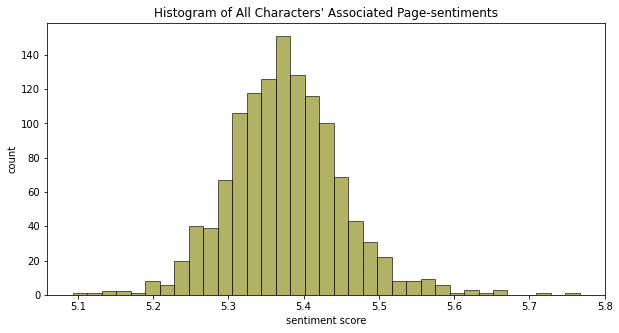

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.hist(sentiment_dict.values(),bins=35,color='olive',alpha=0.6,edgecolor='k')
plt.xlabel('sentiment score')
plt.ylabel('count')
plt.title('Histogram of All Characters\' Associated Page-sentiments')
plt.show()

**Answer:**  
Considering that the score is ranged from 1 to 9 , the wikipedia pages, just as Sune said in the video, are quite neutral in sentiment. All character's associated page sentiment are ranged in (5,6), and the median is around 5.4. 

> What are the 10 characters with happiest and saddest pages?

In [53]:
# sorted sentiment_dict
sentiment_dict_sorted = sorted(sentiment_dict.items(), key = lambda kv:kv[1], reverse=True)

print('the top 10 most happiest character in Marvel Universe:\n{}'.format(sentiment_dict_sorted[:10]))
print('the top 10 most saddest character in Marvel Universe:\n{}'.format(sentiment_dict_sorted[-10:]))

the top 10 most happiest character in Marvel Universe:
[('Free_Spirit_(comics)', 5.76709677419355), ('Super_Rabbit', 5.711050656660413), ('Honey_Lemon', 5.667034883720931), ('Lorna_the_Jungle_Girl', 5.655985576923074), ('Father_Time_(Marvel_Comics)', 5.652517006802722), ('Jungle_Tales', 5.6342077922077936), ('Delilah_(comics)', 5.620652173913044), ('Blue_Diamond_(comics)', 5.6166266666666695), ('Sun_Girl_(Marvel_Comics)', 5.614274809160305), ('Nomad_(comics)', 5.602179836512265)]
the top 10 most saddest character in Marvel Universe:
[('Nightmare_(Marvel_Comics)', 5.1977833333333345), ('Razor_Fist', 5.196812596006143), ('Trash_(comics)', 5.193179723502306), ('Holocaust_(Marvel_Comics)', 5.187002985074619), ('Dark_Beast', 5.15330228948389), ('Hurricane_(comics)', 5.152398104265404), ('Death_(Marvel_Comics)', 5.151057579318442), ('Savage_Steel', 5.142008733624455), ('Death_Metal_(comics)', 5.119311740890688), ('Alternative_versions_of_Doctor_Strange', 5.093333333333334)]


> Now we average the average sentiment of the nodes in each community to find a community level sentiment.

> - Name each community by its three most connected characters.

In [56]:
# get the community infor
commu_file = './data/partition.json'
import json
with open(commu_file,'r') as f:
    partition = json.load(f)
    

# the dict format as {'community':[list of nodes in this community], ...}
community_dict={}
for node in partition.keys():
    if partition[node] not in community_dict.keys():
        community_dict[partition[node]] = [node]
    else:
        community_dict[partition[node]].append(node)

In [63]:
# name the community by the three most connected characters
for commu in community_dict.keys():
    # get the sub network
    subG = Marvel_network.subgraph(community_dict[commu])
    # get the degree and sorted
    d_sorted = sorted(subG.degree, key=lambda x: x[1], reverse=True)
    
    if len(subG.nodes()) >=3:
        first3name = [n for (n,d) in d_sorted[:3]]
    else: # if this community has less than 3 nodes
        first3name = [n for (n,d) in d_sorted]
    new_name = '+'.join(first3name)
    community_dict[new_name] = community_dict.pop(commu)

> (average the average sentiment of the nodes in each community to find a community level sentiment

In [76]:
sentiment_community = {}

for commu in community_dict.keys():
    senti_sum = 0
    node_list = community_dict[commu]
    for n in node_list:
        senti_sum += sentiment_dict[n]
    number_of_nodes = len(node_list)
    avg_senti = senti_sum/number_of_nodes
    sentiment_community[str(commu)] = avg_senti

print('the average sentiment in each community:\n')
for commu in sentiment_community:
    print('{}:{:.4f}'.format(commu,sentiment_community[commu]))

the average sentiment in each community:

Tenebrous_(Marvel_Comics):5.4629
Terraformer_(comics):5.4542
Tremolo_(comics):5.4508
Wildstreak:5.3377
Wing_(Marvel_Comics):5.4065
Wipeout_(comics):5.3305
Wraith:5.4999
New_Warriors+Robbie_Baldwin+Rage_(comics):5.3815
Thor_(Marvel_Comics)+Asgard_(comics)+Loki_(comics):5.3798
Hulk+Doctor_Strange+Silver_Surfer:5.3747
Achebe_(comics):5.4200
Captain_America+Iron_Man+Fantastic_Four:5.3889
Wolverine_(character)+Professor_X+Cyclops_(Marvel_Comics):5.3706
Alternative_versions_of_Doctor_Strange:5.0933
Spider-Man+Doctor_Octopus+Daredevil_(Marvel_Comics_character):5.3489
Sasquatch_(comics)+Vindicator_(comics)+Shaman_(comics):5.3894
Bela_(comics):5.4731
Outlaw_Kid+Rawhide_Kid+Kid_Colt:5.4937
Kiber_the_Cruel:5.2289
Kraken_(Marvel_Comics):5.4169
Locust_(comics):5.4420
Ludi_(comics):5.3956
Lurking_Unknown:5.2277
N'Garai:5.3248
Nightside_(comics):5.4383
Numinus:5.3902
Orator_(comics):5.4221
Otomo_(comics):5.4407
Pasco_(comics):5.4321
Paulie_Provenzano:5.3649
P

> - What are the three happiest communities?
> - what are the three saddest communities?

In [77]:
sentiment_community_sorted = sorted(sentiment_community.items(),key= lambda kv:kv[1],reverse=True)
print('three happiest communities:{}'.format(sentiment_community_sorted[:3]))
print('three saddest communities:{}'.format(sentiment_community_sorted[-3:]))

three happiest communities:[('Tarzan_in_comics', 5.577416637416639), ('Royal_Roy', 5.56388111888112), ('Wraith', 5.499852398523983)]
three saddest communities:[('Kiber_the_Cruel', 5.228852459016395), ('Lurking_Unknown', 5.227692307692308), ('Alternative_versions_of_Doctor_Strange', 5.093333333333334)]


In [80]:
# remove the communityies which only have one node
sentiment_community_sorted_morethanone = [(n,v) for (n,v) in sentiment_community_sorted if len(n.split('+'))>1]
print('three happiest communities(excluded the communities only have one node):{}'.format(sentiment_community_sorted_morethanone[:3]))
print('three saddest communities(excluded the communities only have one node):{}'.format(sentiment_community_sorted_morethanone[-3:]))

three happiest communities(excluded the communities only have one node):[('Outlaw_Kid+Rawhide_Kid+Kid_Colt', 5.493720574694758), ('Rockman_(comics)+Captain_Wonder_(Timely_Comics)+Phantom_Reporter', 5.453897978550775), ('Sasquatch_(comics)+Vindicator_(comics)+Shaman_(comics)', 5.389420505039874)]
three saddest communities(excluded the communities only have one node):[('Hulk+Doctor_Strange+Silver_Surfer', 5.374674207377415), ('Wolverine_(character)+Professor_X+Cyclops_(Marvel_Comics)', 5.370608442669538), ('Spider-Man+Doctor_Octopus+Daredevil_(Marvel_Comics_character)', 5.348918382463619)]


> Do these results confirm what you can learn about each community by skimming the wikipedia pages?

**Answer:**  
可能需要去看一下wiki page